In [4]:
from PIL import Image
import numpy as np
from tifffile import imread
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.morphology import remove_small_objects
from skimage.measure import label

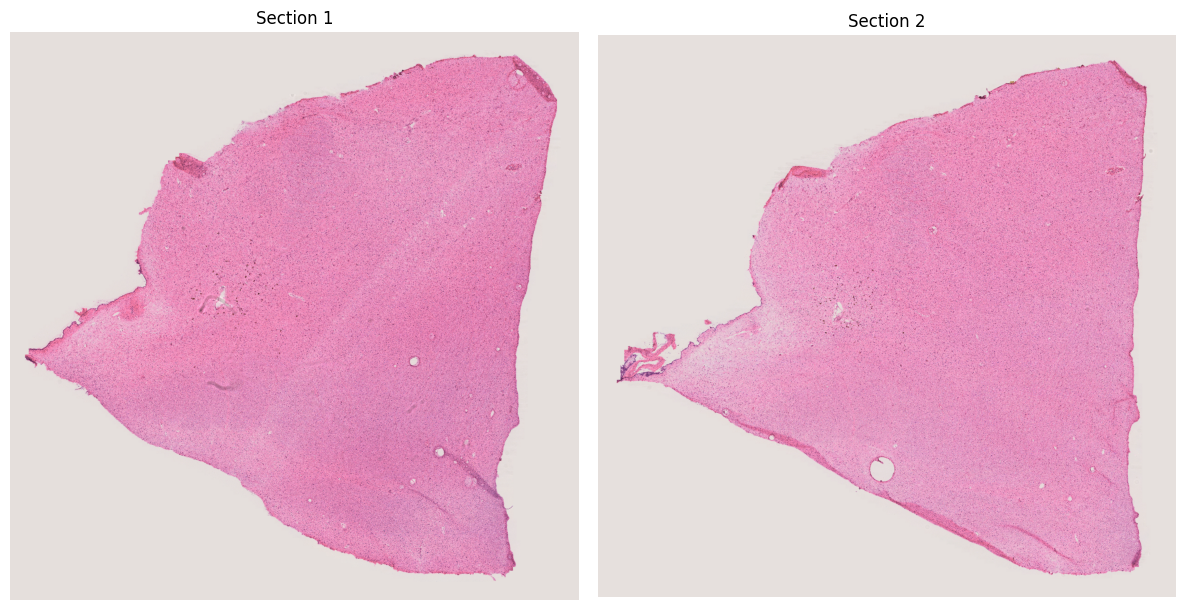

In [5]:
im1_pth = 'test_data/cropped_sections/crop_0.tif'
im2_pth = 'test_data/cropped_sections/crop_1.tif'

# Read images
im1 = imread(im1_pth)
im2 = imread(im2_pth)

# Create figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display first image
axes[0].imshow(im1)
axes[0].axis('off')
axes[0].set_title('Section 1')

# Display second image
axes[1].imshow(im2)
axes[1].axis('off')
axes[1].set_title('Section 2')

plt.tight_layout()
plt.show()

In [6]:
def get_mask(im):
    threshold = 200 # threshold for green channel

    mask = (im[:,:,1] > threshold).astype(float)
    blurred = gaussian_filter(mask, sigma=2)
    mask = blurred < 0.70

    cc_threshold = 100000 # connected components threshold size (keep above)
    mask = remove_small_objects(mask, min_size=cc_threshold)

    labeled_mask = label(mask, connectivity=2)
    return labeled_mask

In [21]:
im1_mask = get_mask(im1)
im2_mask = get_mask(im2)

ds = 8

im1_mask_ds = im1_mask[::ds, ::ds]
im2_mask_ds = im2_mask[::ds, ::ds]

In [57]:
# compute target dimensions
H = max(im1_mask_ds.shape[0], im2_mask_ds.shape[0]) + 100
W = max(im1_mask_ds.shape[1], im2_mask_ds.shape[1]) + 100

# pad each mask to (H,W)
def pad_to(img, H, W):
    pad_h = H - img.shape[0]
    pad_w = W - img.shape[1]
    return np.pad(img,
                  ((0, pad_h), (0, pad_w)),
                  mode='constant', constant_values=0)

im1p = pad_to(im1_mask_ds, H, W)
im2p = pad_to(im2_mask_ds, H, W)

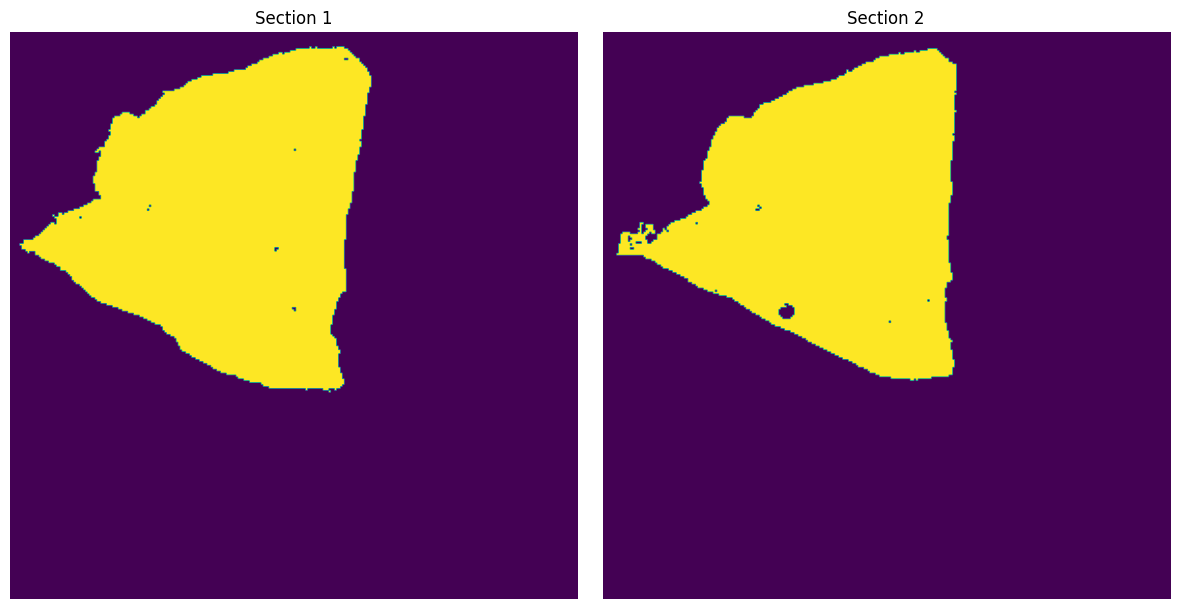

In [58]:
# Create figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display first image
axes[0].imshow(im1p)
axes[0].axis('off')
axes[0].set_title('Section 1')

# Display second image
axes[1].imshow(im2p)
axes[1].axis('off')
axes[1].set_title('Section 2')

plt.tight_layout()
plt.show()

In [61]:
print(im1p.shape)
print(im2p.shape)

(294, 294)
(294, 294)


In [62]:
from skimage.transform import radon, rotate
from scipy.signal import correlate
from skimage.registration import phase_cross_correlation
from scipy.ndimage import fourier_shift
import numpy.fft as fft

In [63]:
theta = np.linspace(0., 180., max(im1p.shape), endpoint=False)
sinogram1 = radon(im1p, theta=theta, circle=False)
sinogram2 = radon(im2p, theta=theta, circle=False)

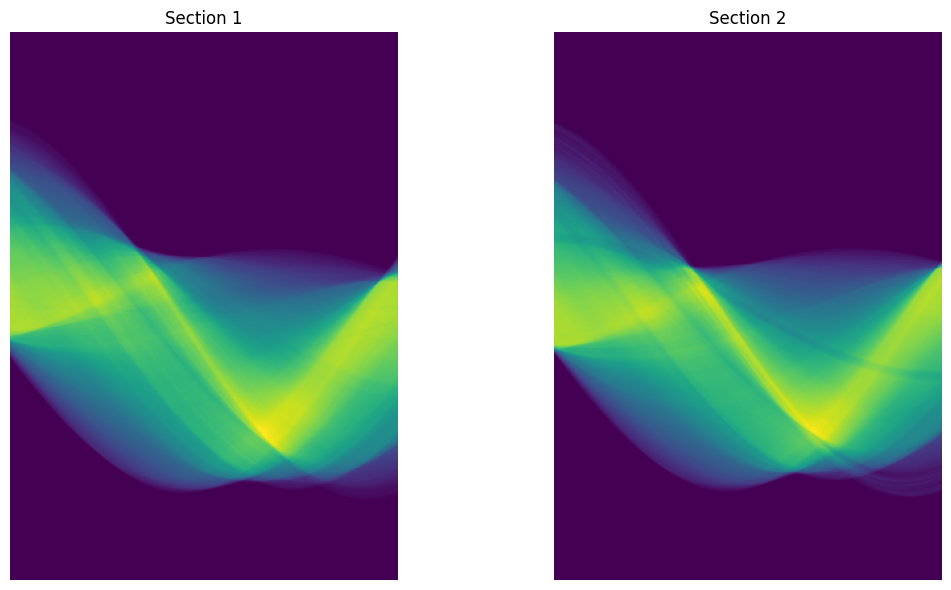

In [64]:
# Create figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display first image
axes[0].imshow(sinogram1)
axes[0].axis('off')
axes[0].set_title('Section 1')

# Display second image
axes[1].imshow(sinogram2)
axes[1].axis('off')
axes[1].set_title('Section 2')

plt.tight_layout()
plt.show()

In [65]:
# sum over projection distances to collapse sinogram to 1D (angle) profiles
proj1 = sinogram1.sum(axis=0)
proj2 = sinogram2.sum(axis=0)

# correlation
corr = correlate(proj1 - proj1.mean(), proj2 - proj2.mean(), mode='full')
shift_idx = np.argmax(corr) - (len(proj1) - 1)
best_angle = theta[shift_idx]

# correlation
corr = correlate(proj1 - proj1.mean(), proj2 - proj2.mean(), mode='full')
shift_idx = np.argmax(corr) - (len(proj1) - 1)
best_angle = theta[shift_idx]

aligned_mask2 = rotate(im2p, best_angle, resize=False, order=0, preserve_range=True).astype(im2p.dtype)
shift, error, diffphase = phase_cross_correlation(im1p, aligned_mask2, upsample_factor=10)

# work in Fourier domain for subpixel accuracy
f2 = fft.fftn(aligned_mask2)
f2_shifted = fourier_shift(f2, shift)
final_mask2 = np.abs(fft.ifftn(f2_shifted)) > 0.5

In [66]:
print(im1p.shape)
print(im2p.shape)

(294, 294)
(294, 294)


In [67]:
from scipy.ndimage import center_of_mass, fourier_shift
from numpy.fft import fftn, ifftn

# compute COM and shift im1p so its COM sits at the image center
com = center_of_mass(im1p)
center = np.array(im1p.shape) / 2
shift_to_center = center - com

F = fftn(im1p)
Fc = fourier_shift(F, shift_to_center)
im1p = (np.abs(ifftn(Fc)) > 0.5).astype(im1p.dtype)

# compute COM and shift im2p so its COM sits at the image center
com = center_of_mass(im2p)
center = np.array(im2p.shape) / 2
shift_to_center = center - com

F = fftn(im2p)
Fc = fourier_shift(F, shift_to_center)
im2p = (np.abs(ifftn(Fc)) > 0.5).astype(im2p.dtype)

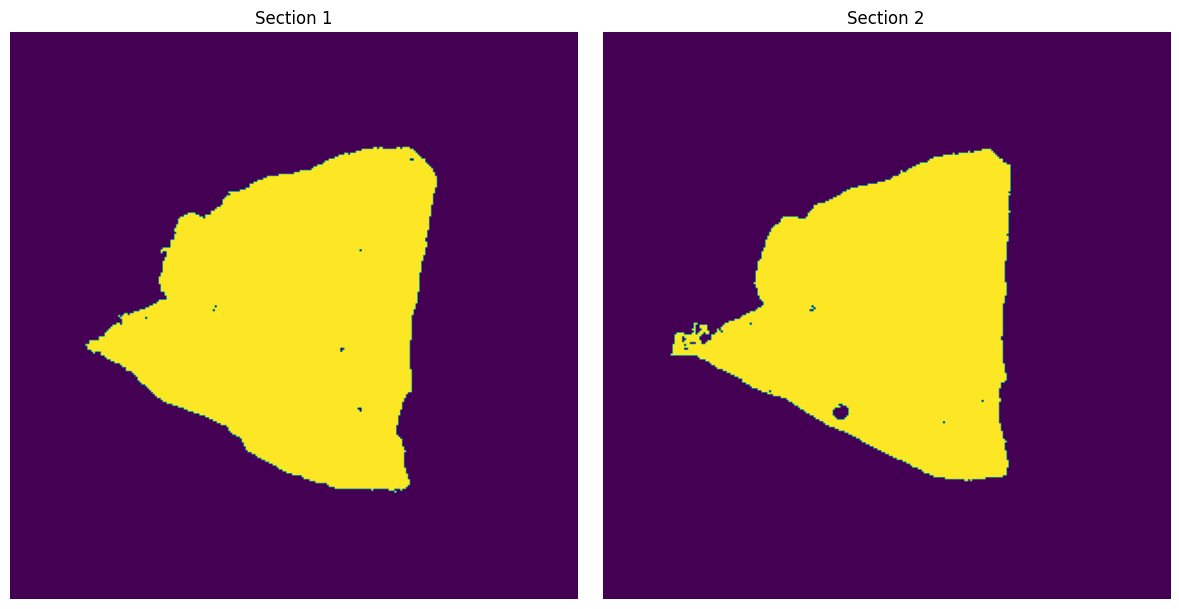

In [68]:
# Create figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display first image
axes[0].imshow(im1p)
axes[0].axis('off')
axes[0].set_title('Section 1')

# Display second image
axes[1].imshow(im2p)
axes[1].axis('off')
axes[1].set_title('Section 2')

plt.tight_layout()
plt.show()

In [71]:
# 1) sinograms
theta = np.linspace(0., 180., im1p.shape[0], endpoint=False)
sino1 = radon(im1p, theta=theta, circle=False)
sino2 = radon(im2p, theta=theta, circle=False)

# 2) angular profiles
proj1 = sino1.sum(0) - sino1.sum(0).mean()
proj2 = sino2.sum(0) - sino2.sum(0).mean()

# 3) find lag → angle
corr = correlate(proj1, proj2, mode='full')
lags = np.arange(-len(proj1)+1, len(proj1))
best_lag = lags[np.argmax(corr)]
delta = theta[1] - theta[0]
best_angle = best_lag * delta

# 4) rotate im2p by –best_angle
aligned = rotate(im2p,
                 -best_angle,
                 resize=False,
                 order=0,
                 preserve_range=True).astype(im2p.dtype)

# 5) subpixel alignment
shift, error, _ = phase_cross_correlation(im1p, aligned, upsample_factor=10)
F = fftn(aligned)
F_shifted = fourier_shift(F, shift)
final_mask2 = (np.abs(ifftn(F_shifted)) > 0.5).astype(im2p.dtype)

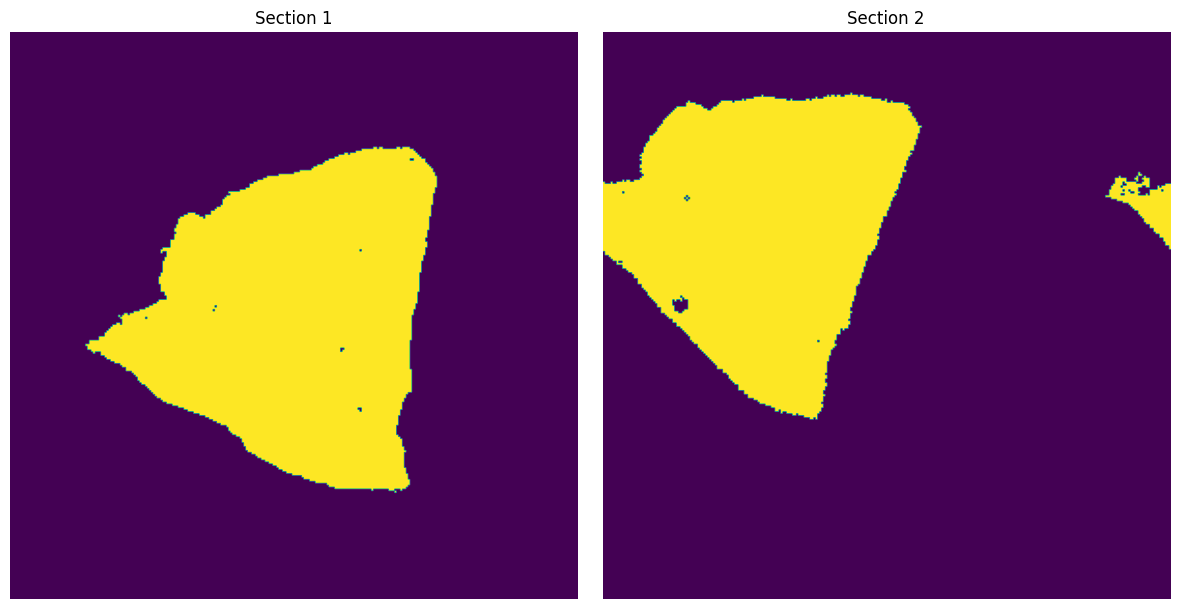

In [72]:
# Create figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display first image
axes[0].imshow(im1p)
axes[0].axis('off')
axes[0].set_title('Section 1')

# Display second image
axes[1].imshow(final_mask2)
axes[1].axis('off')
axes[1].set_title('Section 2')

plt.tight_layout()
plt.show()